### Data Preprocessing

In [1]:
%run preprocessing.py
print ("shape of usersXprod :", usersXprod.shape)


import data
merge orders and order_products__prior
size of prd features : 5
size of users features : 13
nb of usersXproducts features : 13
merge prod, user and usersXprod feature on usersXprod
order row 2000000
order row 4000000
order row 6000000
order row 8000000
order row 10000000
order row 12000000
shape of usersXprod : (13307953, 32)


In [2]:
# 對於購買力很差的顧客做篩選
# 針對一些超愛reordered跟超愛亂買的消費者做刪除 (high, normal, low)
# (train, test): (131209, 75000)

t_afew = 20
t_low = 0.1

afewXlow = usersXprod[(usersXprod.eval_set == "train")&(usersXprod.user_total_product <= t_afew)&(usersXprod.user_reorder_ratio < t_low)]
afew = usersXprod[(usersXprod.eval_set == "train")&(usersXprod.user_total_product <= t_afew)]
low = usersXprod[(usersXprod.eval_set == "train")&(usersXprod.user_reorder_ratio < t_low)]

print ("user of afewXlow :", len(set(afewXlow.user_id)))
print ("user of afew :", len(set(afew.user_id)))
print ("user of low :", len(set(low.user_id)))
print ("usersXprod of afewXlow :", afewXlow.shape[0]/usersXprod[(usersXprod.eval_set == "train")].shape[0])
print ("usersXprod of afew :", afew.shape[0]/usersXprod[(usersXprod.eval_set == "train")].shape[0])
print ("usersXprod of low :", low.shape[0]/usersXprod[(usersXprod.eval_set == "train")].shape[0])

del afewXlow
del afew
del low

user of afewXlow : 2006
user of afew : 13439
user of low : 5076
usersXprod of afewXlow : 0.0030049579564303515
usersXprod of afew : 0.014907970950106441
usersXprod of low : 0.01563366369463038


In [3]:
con_train = (usersXprod.eval_set == "train")#&(usersXprod.user_reorder_ratio >= t_low)
con_test = (usersXprod.eval_set == "test")

train = usersXprod[con_train]
train.drop(['eval_set'], axis=1, inplace = True)

X_test = usersXprod[con_test]
X_test.drop(['eval_set'], axis=1, inplace = True)

print("size of training set :", train.shape[0])
print("size of testing set  :", X_test.shape[0])

# subset much fast!
train = train[train.index % 10 == 1]
print ("size of subset :", train.shape[0])


size of training set : 8474661
size of testing set : 4833292
size of subset : 847405


In [6]:
# X, y, class_weight
X = train.drop(["reordered"], axis = 1)
y = train[["reordered"]]

class_weight_0 = (y.shape[0] - np.sum(y.reordered)) / y.shape[0]
class_weight_1 = np.sum(y.reordered) / y.shape[0]
print("Size of features of dataset :", X.shape[1])
print("Class weight of 0 :", class_weight_0)
print("Class weight of 1 :", class_weight_1)


Size of features of dataset : 30
Class weight of 0 : 0.9023619166750255
Class weight of 1 : 0.09763808332497448


In [7]:
# train set convert to form of submit

train_details = ordert[["user_id", "order_id", "product_id", "reordered"]]

try:
    df_train_gt = pd.read_csv('train.csv', index_col='order_id')
except:
    train_gtl = []

    for uid, subset in train_details.groupby('user_id'):
        subset1 = subset[subset.reordered == 1]
        oid = subset.order_id.values[0]

        if len(subset1) == 0:
            train_gtl.append((oid, 'None'))
            continue

        ostr = ' '.join([str(int(e)) for e in subset1.product_id.values])
        # .strip is needed because join can have a padding space at the end
        train_gtl.append((oid, ostr.strip()))

    df_train_gt = pd.DataFrame(train_gtl)

    df_train_gt.columns = ['order_id', 'products']
    df_train_gt.set_index('order_id', inplace=True)
    df_train_gt.sort_index(inplace=True)
    
    df_train_gt.to_csv('train.csv')


### Define Function

In [8]:
import time

# 計時
class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name)
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

# 整理成submit形式
def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

def model_cv(model, X_train, y_train, X_val, y_val, features_to_use):
    model.fit(X = X_train[features_to_use].values,
              y = y_train.values)
    pred = model.predict_proba(X_val[features_to_use].values)
    return pred

# prediction compare with target
def compare_results(df_gt, df_preds):
    df_gt_cut = df_gt.loc[df_preds.index]
    
    f1 = []
    for gt, pred in zip(df_gt_cut.sort_index().products, df_preds.sort_index().products):
        lgt = gt.replace("None", "-1").split(' ')
        lpred = pred.replace("None", "-1").split(' ')

        rr = (np.intersect1d(lgt, lpred))
        precision = np.float(len(rr)) / len(lpred)
        recall = np.float(len(rr)) / len(lgt)

        denom = precision + recall
        f1.append(((2 * precision * recall) / denom) if denom > 0 else 0)
    
    return(np.mean(f1))

# testing and convert to form of submittion
def testing(model, test0, threshold=0.21):
    model.fit(X, y)
    test0.loc[:, 'reordered'] = (model.predict_proba(test.values)[:,1] > threshold).astype(int)
    test0.loc[:, 'product_id'] = test0.product_id.astype(str)

    submit = ka_add_groupby_features_n_vs_1(test0[test0.reordered == 1], 
                                            group_columns_list = ['order_id'],
                                            target_columns_list = ['product_id'],
                                            methods_list = [lambda x: ' '.join(set(x))],
                                            keep_only_stats = True)
    sample_submission = pd.read_csv("sample_submission.csv")
    print (len(sample_submission), len(submit))

    submit.columns = sample_submission.columns.tolist()
    submit_final = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
    return submit_final


In [9]:
# cross validation: 用不同user_id去做cross validation

def cross_val(model):
    df_cvfolds = []
    cb = []
    for fold in range(4):
        train_subset = train[train.user_id % 4 != fold]
        valid_subset = train[train.user_id % 4 == fold]

        X_train = train_subset.drop('reordered', axis=1)
        y_train = train_subset.reordered

        X_val = valid_subset.drop('reordered', axis=1)
        y_val = valid_subset.reordered

        val_index = X_val[['user_id', 'product_id', 'order_id']]
    
        features_to_use = list(X_train.columns)
        features_to_use.remove('user_id')
        features_to_use.remove('product_id')
        features_to_use.remove('order_id')

        rawpreds = model_cv(model, X_train, y_train, X_val, y_val, features_to_use)
    
        lim = .202
        val_out = val_index.copy()

        val_out.loc[:, 'reordered'] = (rawpreds[:,1] > lim).astype(int)
        val_out.loc[:, 'product_id'] = val_out.product_id.astype(str)
        presubmit = ka_add_groupby_features_n_vs_1(val_out[val_out.reordered == 1], 
                                                   group_columns_list = ['order_id'],
                                                   target_columns_list = ['product_id'],
                                                   methods_list = [lambda x: ' '.join(set(x))],
                                                   keep_only_stats = True)

        presubmit = presubmit.set_index('order_id')
        presubmit.columns = ['products']

        fullfold = pd.DataFrame(index = val_out.order_id.unique())

        fullfold.index.name = 'order_id'
        fullfold['products'] = ['None'] * len(fullfold)

        fullfold.loc[presubmit.index, 'products'] = presubmit.products

        print(fold, compare_results(df_train_gt, fullfold))

        df_cvfolds.append(fullfold)
    df_cv = pd.concat(df_cvfolds)
    print("===> total prediction VS target", compare_results(df_train_gt, df_cv))


### Building Model & Training

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, ExtraTreesClassifier


/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
model = DecisionTreeClassifier()
cross_val(model)


add stats features
time lapsing 1.060938835144043 s 

0 0.0858827006292
add stats features
time lapsing 0.9186413288116455 s 

1 0.0829764912909
add stats features
time lapsing 0.8607559204101562 s 

2 0.0832782231363
add stats features
time lapsing 0.9002869129180908 s 

3 0.0832966675598
===> total prediction VS target 0.0838603133683


In [15]:
rfc = RandomForestClassifier(verbose = 0)
params = {'n_estimators' : [ 300 , 500 ],
          'max_features' : [ 4 , 5 , 6 ]}

# Run the grid search
grid_obj = GridSearchCV(rfc, params, scoring = 'roc_auc', verbose = 10)
grid_obj = grid_obj.fit(X=train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis=1),
                        y=train.reordered)

clf = grid_obj.best_estimator_
print(clf)

In [16]:
cross_val(model = rfc)

add stats features
time lapsing 0.9567239284515381 s 

0 0.10489077371
add stats features
time lapsing 1.0086829662322998 s 

1 0.103615790758
add stats features
time lapsing 1.0046360492706299 s 

2 0.103306652754
add stats features
time lapsing 0.9848940372467041 s 

3 0.103143195294
===> total prediction VS target 0.103740079765


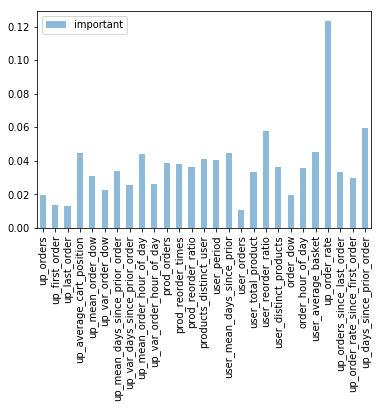

In [18]:
from matplotlib import pyplot as plt

imp = pd.DataFrame(data = model.feature_importances_,
                   index = train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis=1).columns,
                   columns = ["important"])
imp.plot.bar(alpha=0.5)
plt.show()

In [19]:
class  Ensemble (object) :
    def  __init__ (self, n_folds, stacker, base_models) :
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models
    def  fit_predict (self, X, y, T) :
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        folds = list(KFold(len(y), n_folds=self.n_folds, shuffle= True , random_state= 2016))
        S_train = np.zeros((X.shape[ 0 ], len(self.base_models)))
        S_test = np.zeros((T.shape[ 0 ], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[ 0 ], len(folds)))
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                # y_holdout = y[test_idx]
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]
            S_test[:, i] = S_test_i.mean( 1 )
        self.stacker.fit(S_train, y)
        y_pred = self.stacker.predict(S_test)[:]
        return y_pred